In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown
%matplotlib inline  
from IPython.display import FileLink, FileLinks


In [2]:
df = pd.read_csv('./pilot.csv')
df['logs'] = df['logs'].map(lambda x: json.loads(x) if not pd.isnull(x) else pd.NA)

df.loc[df['participant_id'].isna(),'participant_id'] = 'test'
df['__INDEX__'] = df['__INDEX__'].map(json.loads)

df.loc[df['participant_id'] == 'arnav','participant_id'] = "1"
df.loc[df['participant_id'] == 'karthik','participant_id'] = "2"
df.loc[df['participant_id'] == 'majeed','participant_id'] = "3"
df = df[~df.participant_id.isin(["bdog","9jsrk50xr9c-default","test","p6p94dhwo5-default","blaine", "unknown", "1", "2", "3"])].copy()
def find_start(x):
    if type(x) != list:
        return pd.NA
    
    for log in x:
        if log['type'] == 'START':
            return log['timestamp']
    
    return pd.NA

def find_end(x):
    if type(x) != list:
        return pd.NA
    for log in x:
        if log['type'] == 'END':
            return log['timestamp']
    
    return pd.NA


def extract_metadata(x):
#     print(pd.Series(json.loads(x['metadata'])))
    d = json.loads(x['metadata'])
    if 'participant_id' in d:
        del d['participant_id']
    return pd.Series(d)
    

df['start'] = df['logs'].map(find_start)
df['end'] = df['logs'].map(find_end)
# df = df.apply(find_random_pid, axis=1)
df = pd.concat([df, df.apply(extract_metadata, axis=1)], axis=1)


In [3]:
df['task'].unique()


array(['ConsentForm', 'BeginScreen', 'DivergentTest', 'Tutorial',
       'MousePositioning', 'CommandSelection', 'Questionnaire', 'NasaTlx',
       'AdditionalComments', 'S3Upload', 'RedirectTask'], dtype=object)

In [4]:
df['participant_id'].unique()


array(['5a03d20a7ecfc50001be0a7a', '5a6032228e625900017657f4',
       '5ad9cc7ddfcfcb0001e667f3', '5ae53e7f58af2400010a39e8',
       '5af59378f856320001cf2ffc', '5c50046b2b89f500015e5f6b',
       '5c6480b5f9b6300001c9d52c', '5c90094e71f3100016181ea9',
       '5c9c3ae2d40ce20014233de6', '5cfb5233df7d70001619ca90',
       '5d0c16dfaf24de00012ea950', '5d2a49241d8d930001c263a7',
       '5da6139c002c29001335b5a2', '5dd43df7e0b21b434418ae6c',
       '5e2c9026f4a3052be159c494', '5e574f393e26c90f2b47b96c',
       '5e6550ab777c592d731cc94b', '5e82a76d09f66f9cd3aeb0e7',
       '5edfb0770fb0722aa3839b6d', '5f0a5a99dbbf721316f118e2',
       '5ff39ec71d6cb49c6c906727', '6043cbd95042bc3eba7b4bc1',
       '6045e5cdb5547f7347302e2b', '60e797b64fca2922f9cd51af',
       '60fcc5e427934cc89984c7f6', '60fd3245706969157168ad50',
       '60fd9e8a7c7bd89ff4af7816', '6109c368656980a1609329ed',
       '610cd0b96470d70ab18955fa', '610f08f3d1314c14931e2829',
       '61105071fe05cd89830dcc43', '6110b152a9620d7ecdb

In [5]:
def rename_participants(x):
#     print(x['participant_id'])
#     print(pd.isna(x['participant_id']))
    
    if pd.isna(x['participant_id']) or x['participant_id'] == 'unknown':
        x['participant_id'] = x['participant']
    return x
df = df.apply(rename_participants, axis=1)

In [6]:
gdf = df.groupby(['participant_id']).agg({'start' : 'min', 'end' : 'max'}).reset_index()
gdf['duration'] = gdf['end'] - gdf['start']
gdf['duration'] / 1000 / 60

0     69.870683
1     24.938833
2     33.834700
3     28.385167
4     32.355683
5     30.085000
6     38.999267
7     59.292033
8     27.764483
9     72.199083
10    31.748717
11    31.492617
12    26.054017
13    26.580767
14    28.698883
15    30.892750
16    33.516567
17    26.019417
18    28.064000
19    28.432833
20    38.448233
21    29.009217
22    29.656100
23    32.789917
24    28.309150
25    32.164067
26    25.004967
27    29.742367
28    34.537317
29    38.627467
30    28.204633
31    27.467083
32    53.142217
33    35.351850
34    25.764317
35    43.165383
36    45.500750
37    41.220683
38    42.022650
39    33.870733
40    32.002200
41    35.490717
42    29.476233
43    31.007300
Name: duration, dtype: float64

# Dataframe Creation

## Selection

In [7]:
selection = df[df['task'] == 'CommandSelection'].copy()


def extract_selection(row):
    errors = 0
    start = None
    end = None
    for log in row['logs']:
        if log['type'] == 'WRONG_COMMAND':
            errors += 1
        if log['type'] == 'START':
            start = log['timestamp']
        if log['type'] == 'END':
            end = log['timestamp']
    row['errors'] = errors
    row['has_error'] = errors > 0
    row['duration_milliseconds'] = end - start
    row['duration_minutes'] = row['duration_milliseconds'] / 1000 / 60

    return row
selection['trial'] = selection['__INDEX__'].map(lambda x: x[2])
selection['trial_total'] = selection['__INDEX__'].map(lambda x: x[0] * x[1])

selection = selection[['participant_id', '__INDEX__', 'logs', 'command', 'trial','trial_total', 'menu']]

selection = selection.apply(extract_selection, axis=1)


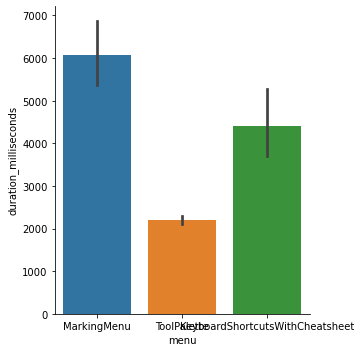

In [8]:
sns.catplot(data=selection, kind="bar", x='menu', y='duration_milliseconds')

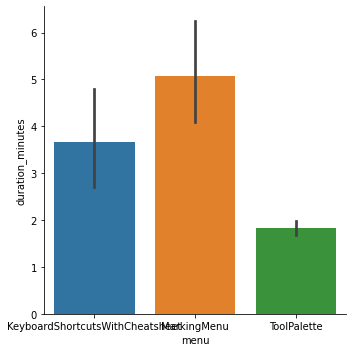

In [9]:
sns.catplot(data=selection.groupby(['participant_id','menu']).sum().reset_index(), kind="bar", x='menu', y='duration_minutes')

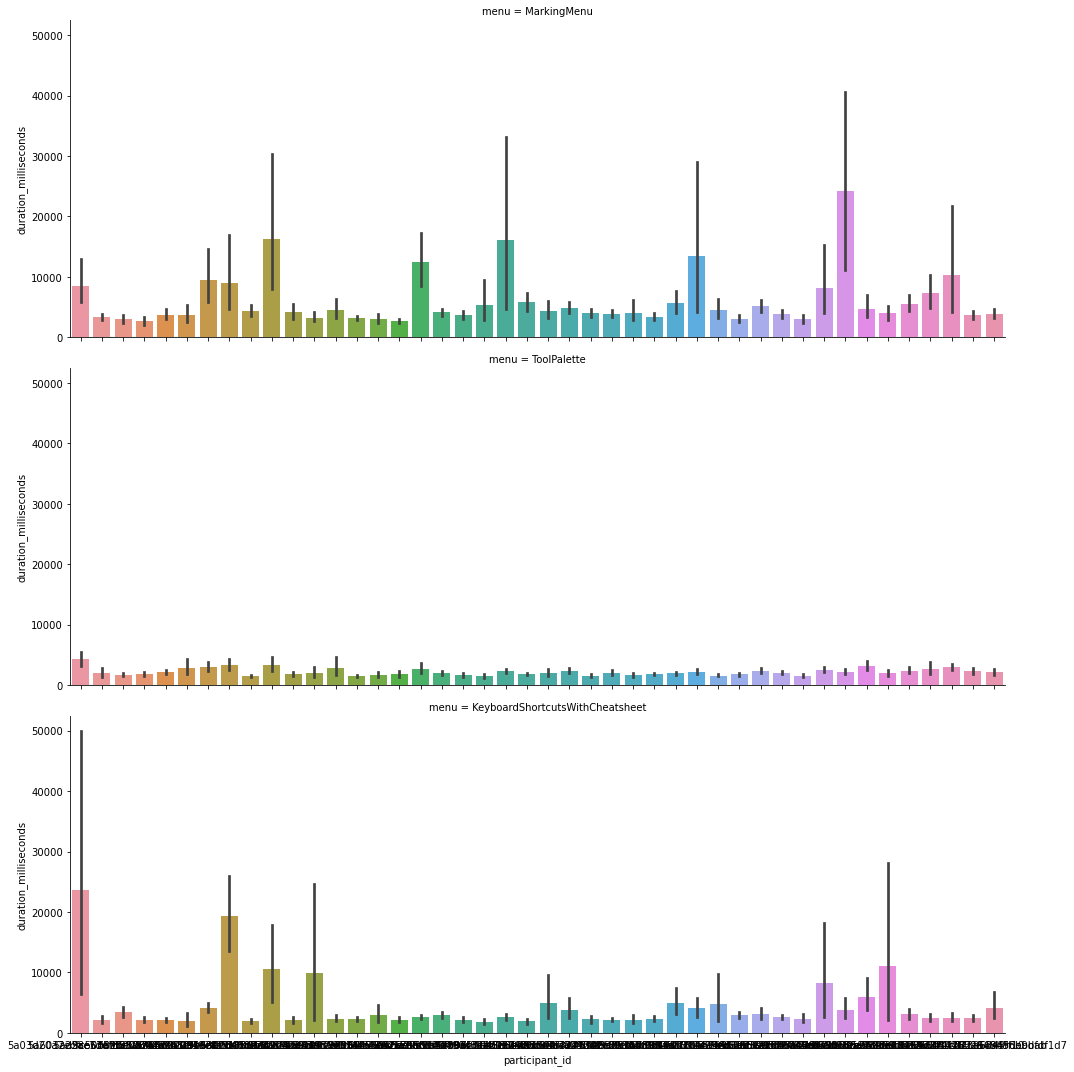

In [10]:
sns.catplot(data=selection, kind="bar", x='participant_id', y='duration_milliseconds', row='menu', height=5, aspect=15/5)

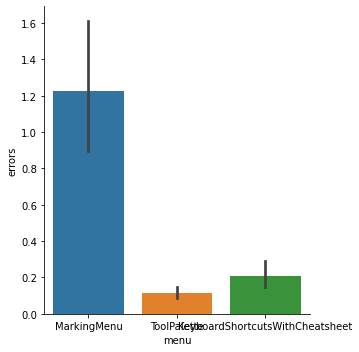

In [11]:
sns.catplot(data=selection, kind="bar", x='menu', y='errors')

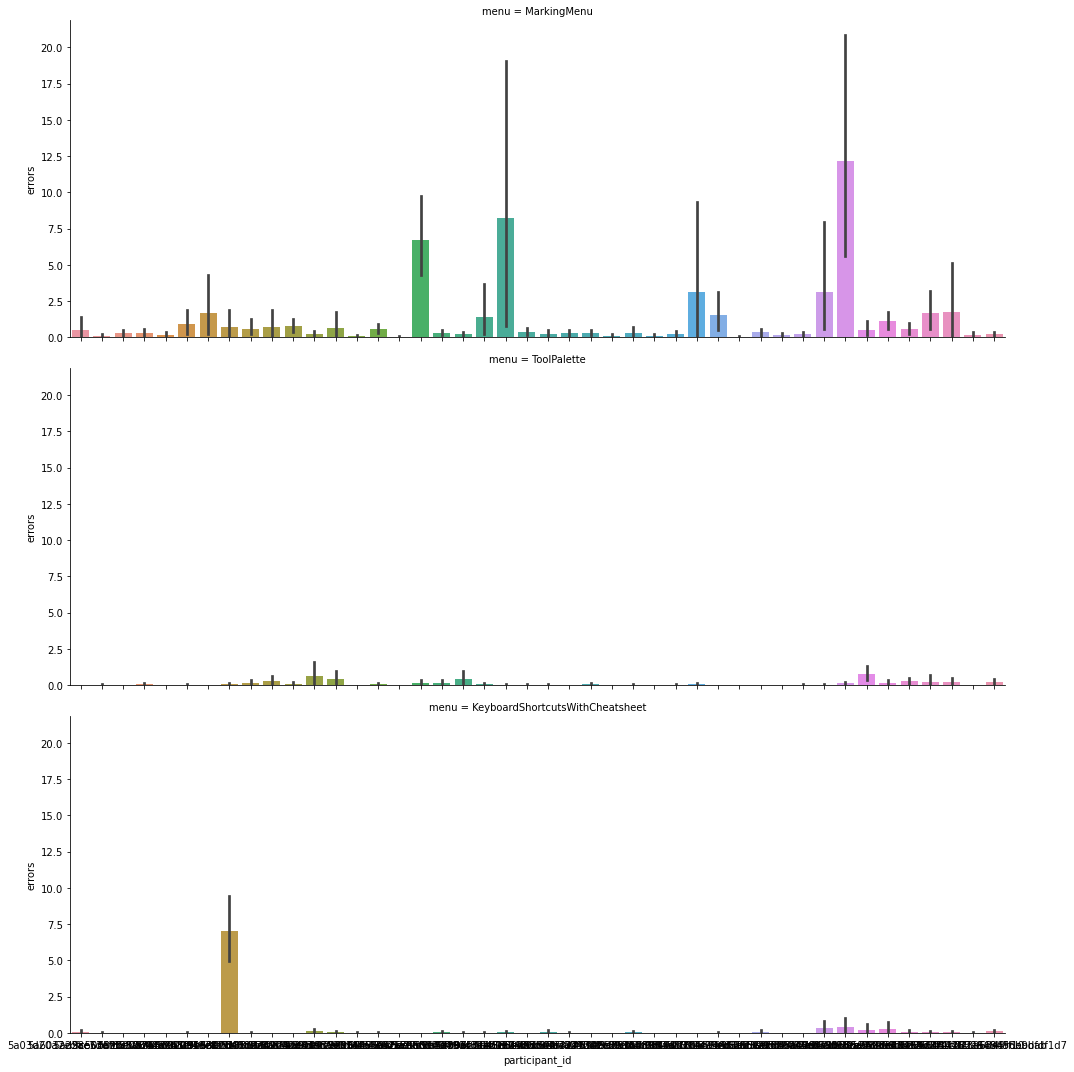

In [12]:
sns.catplot(data=selection, kind="bar", x='participant_id', y='errors', row='menu', height=5, aspect=15/5)

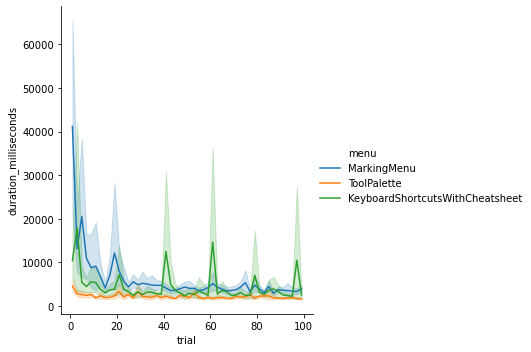

In [13]:
sns.relplot(data=selection,kind='line', x='trial', y='duration_milliseconds', hue="menu")

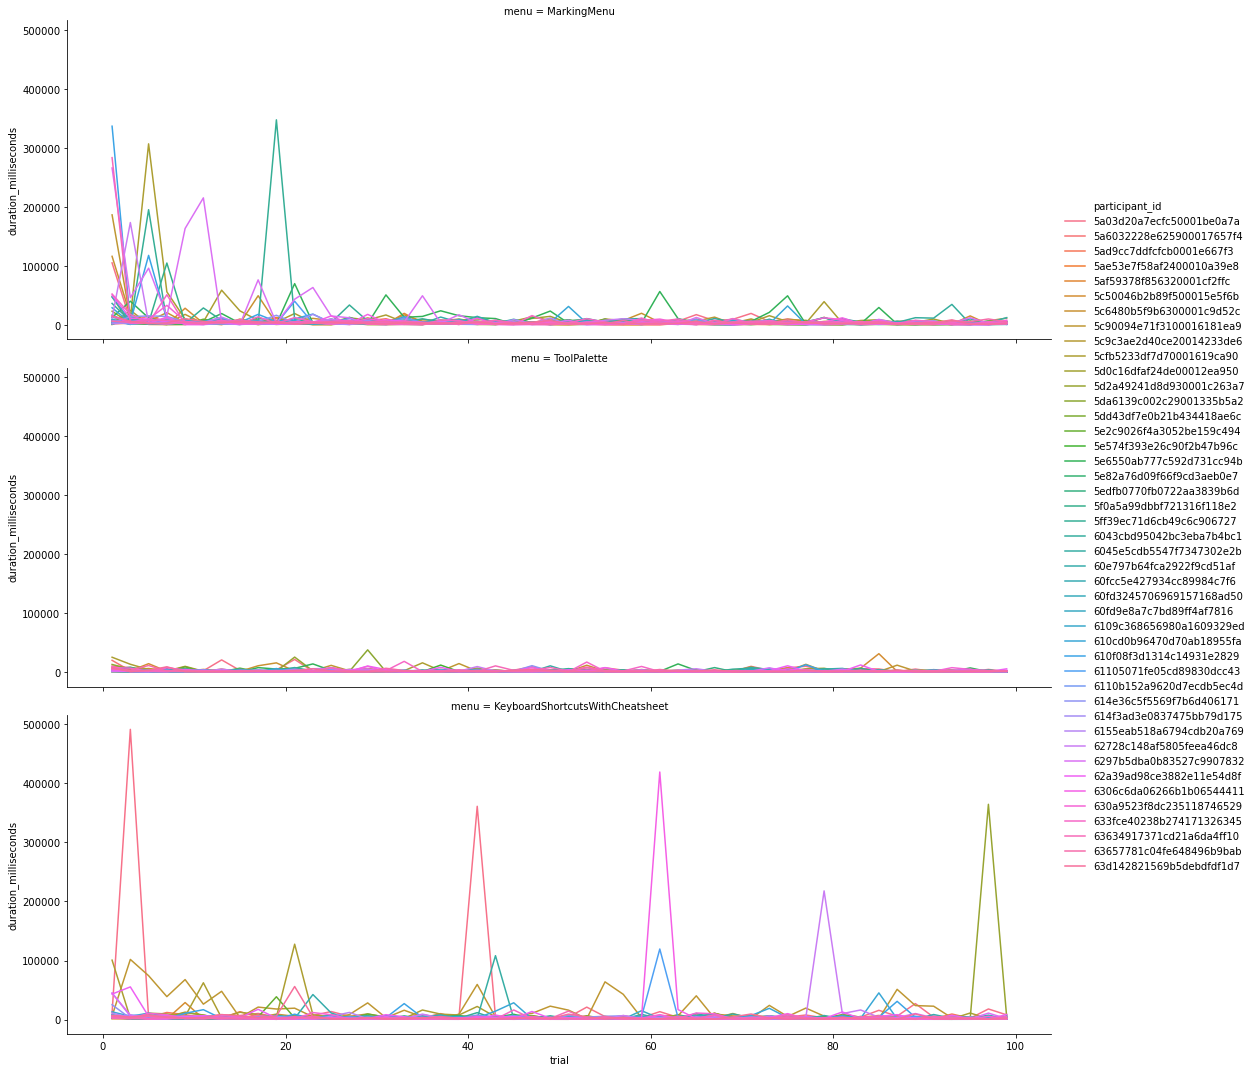

In [14]:
sns.relplot(data=selection, kind="line", x='trial', y='duration_milliseconds', row='menu', hue='participant_id', height=5, aspect=15/5)

## Creativity

In [15]:
unusual_uses = df[df['task'] == 'DivergentTest'].copy()

unusual_uses.fillna({'menu':'baseline'}, inplace=True)

# TODO: so the issue here is that we have multiple rows per group.

def extract_unusual_uses(g):
    for index, row in g.iterrows():
        if not isinstance(row['logs'], list):
            return pd.Series(pd.NA)

        for log in row['logs']:
            if log['type'] == 'DivergentTest':
                new_df = pd.DataFrame(log['values'], columns=['values'])
                new_df['topTwo'] = False
                # TODO: just need to pad the Nones with some falses to make things worlk

                new_df.loc[list(map(bool, log['topTwo'])) + [False] * (len(log['values']) - len(log['topTwo'])), 'topTwo'] = True
                return new_df
        
unusual_uses = unusual_uses.groupby(['participant_id', 'menu', 'object']).apply(extract_unusual_uses).reset_index()
del unusual_uses['level_3']
# del unusual_uses[0]

In [16]:
unusual_uses

,participant_id,menu,object,values,topTwo
0,5a03d20a7ecfc50001be0a7a,baseline,brick,as a doorstop,False
1,5a03d20a7ecfc50001be0a7a,baseline,brick,as a weapon,False
2,5a03d20a7ecfc50001be0a7a,baseline,brick,to break apart drywall,True
3,5a03d20a7ecfc50001be0a7a,baseline,brick,as a paper weight,False
4,5a03d20a7ecfc50001be0a7a,baseline,brick,to break into pieces and grind into powder and...,True
...,...,...,...,...,...
1461,63d142821569b5debdfdf1d7,baseline,newspaper,medicine,False
1462,63d142821569b5debdfdf1d7,baseline,shoe,weapon,True
1463,63d142821569b5debdfdf1d7,baseline,shoe,god,False
1464,63d142821569b5debdfdf1d7,baseline,shoe,device,True


In [17]:
unusual_uses[unusual_uses['topTwo']].to_csv('./toptwo.csv', index=False)
display(FileLink('./toptwo.csv'))
unusual_uses[unusual_uses['topTwo']]

/Users/blainelewis/research/creativity-experiment/analysis/toptwo.csv

,participant_id,menu,object,values,topTwo
2,5a03d20a7ecfc50001be0a7a,baseline,brick,to break apart drywall,True
4,5a03d20a7ecfc50001be0a7a,baseline,brick,to break into pieces and grind into powder and...,True
5,5a03d20a7ecfc50001be0a7a,baseline,knife,as a palette knife,True
6,5a03d20a7ecfc50001be0a7a,baseline,knife,as a mirror,True
8,5a03d20a7ecfc50001be0a7a,baseline,newspaper,as a dance prop,True
...,...,...,...,...,...
1456,63d142821569b5debdfdf1d7,baseline,knife,medicine,True
1457,63d142821569b5debdfdf1d7,baseline,newspaper,as a cover,True
1460,63d142821569b5debdfdf1d7,baseline,newspaper,surgery,True
1462,63d142821569b5debdfdf1d7,baseline,shoe,weapon,True


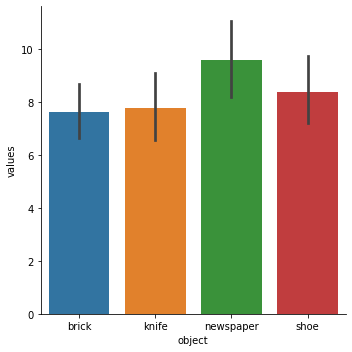

In [18]:
sns.catplot(data=unusual_uses.groupby(['participant_id','menu', 'object']).count().reset_index(), kind="bar", x='object', y='values')

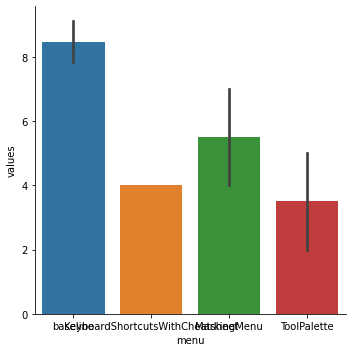

In [19]:
sns.catplot(data=unusual_uses.groupby(['participant_id','menu', 'object']).count().reset_index(), kind="bar", x='menu', y='values')

In [20]:
unusual_uses.groupby(['participant_id','menu','object']).count()

values  topTwo
participant_id           menu     object                   
5a03d20a7ecfc50001be0a7a baseline brick           5       5
                                  knife           2       2
                                  newspaper       7       7
                                  shoe            4       4
5a6032228e625900017657f4 baseline brick          10      10
...                                             ...     ...
63657781c04fe648496b9bab baseline shoe           14      14
63d142821569b5debdfdf1d7 baseline brick           5       5
                                  knife           1       1
                                  newspaper       5       5
                                  shoe            4       4

[176 rows x 2 columns]

In [21]:
tlx = df[df['task'] == 'NasaTlx']


def extract_tlx(row):
    if not isinstance(row['logs'], list):
        return pd.Series(pd.NA)
    
    for log in row['logs']:
        if log['type'] == 'NasaTlx':
            return pd.Series(log['responses'])
tlx = pd.concat([tlx, tlx.apply(extract_tlx, axis=1)], axis=1)

metrics = 'Mental Demand	Physical Demand	Temporal Demand	Performance	Effort	Frustration'.split('	')

melted_tlx = pd.melt(tlx, id_vars=list(set(tlx.columns) - set(metrics)), value_vars=metrics)

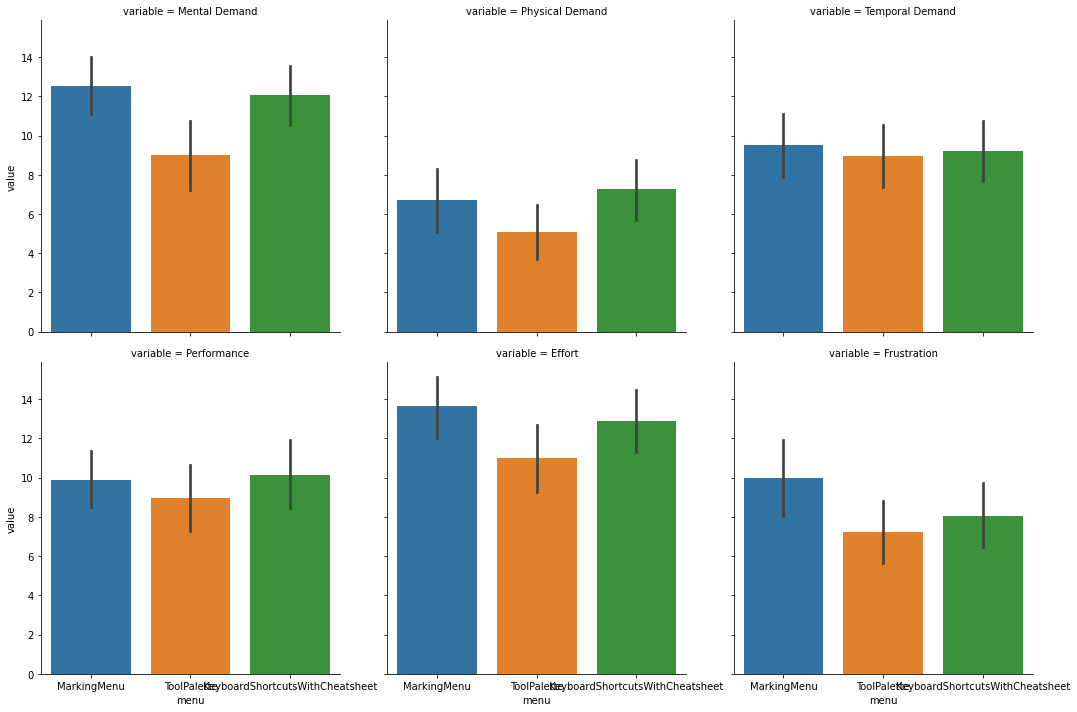

In [22]:
sns.catplot(data=melted_tlx, kind="bar", x='menu', y='value', col="variable", col_wrap=3)


In [23]:
questionnaire = df[df['task'] == 'Questionnaire']

def extract_questionnaire(row):
    if not isinstance(row['logs'], list):
        return pd.Series(pd.NA)

    for log in row['logs']:
        if log['type'] == 'QuestionnaireResponses':
            return pd.Series(log['responses'])
        
questionnaire = pd.concat([questionnaire, questionnaire.apply(extract_questionnaire, axis=1)], axis=1)
# questionnaire['felt'] = questionnaire['I felt creative while I was selecting commands.']
# questionnaire['use'] = questionnaire['I would like to use that command selection technique while doing a creative task like drawing or writing a story.']



In [24]:
questionnaire[questionnaire['felt'].isna()]

,order,participant_id,metadata,version,tasks,ResolutionChecker,__INDEX__,participant_number,task,content,...,session_id,sizeAvailH,sizeAvailW,sizeInH,sizeInW,sizeScreenH,sizeScreenW,study_id,felt,imagine


## I felt creative while I was selecting commands.

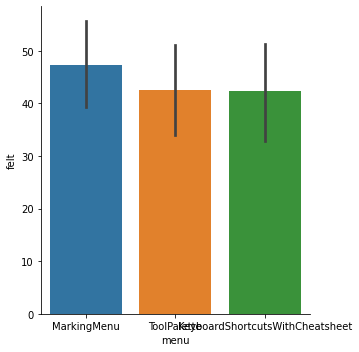

In [25]:
sns.catplot(data=questionnaire, kind="bar", x='menu', y='felt')

## I would like to use that command selection technique while doing a creative task like drawing or writing a story.

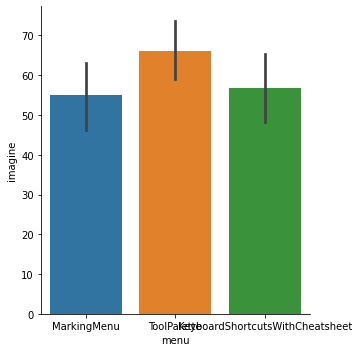

In [26]:
sns.catplot(data=questionnaire, kind="bar", x='menu', y='imagine')

In [27]:
comments = df[df['task'] == 'AdditionalComments'].copy()

def find_log(logs):
    for log in logs:
        if log['type'] == 'COMMENTS':
            return log['data']
        
comments['comments'] = comments['logs'].map(find_log)


comments.style.set_properties(subset=['comments'], **{'width': '800px'})
comments[['comments']]


,comments
319,
641,thanks for opportunity
963,"the mouse select one lagged a lot, and if I di..."
1606,
1928,
2250,It was different and very interesting. I learn...
2572,n/a
2894,
3216,No issues.
3538,Thank you for allowing me to participate in yo...
